In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(
            lookback=1, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i]]
                for i in range(4)
                # for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (15): 128325 (0.8180796661086522, DCDD)
WORST AGENT (230): 67134 (0.21455022373090574, DCDD)


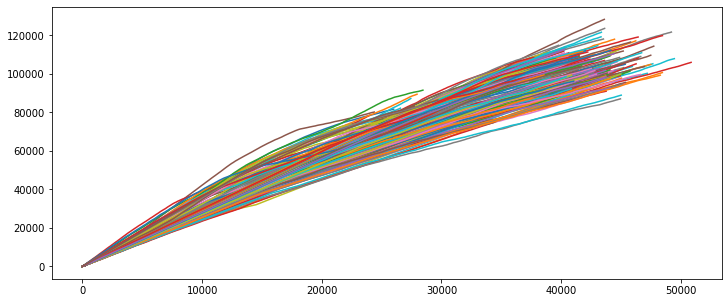

In [7]:
POPULATION = (32, 8)
ROUNDS = 20_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

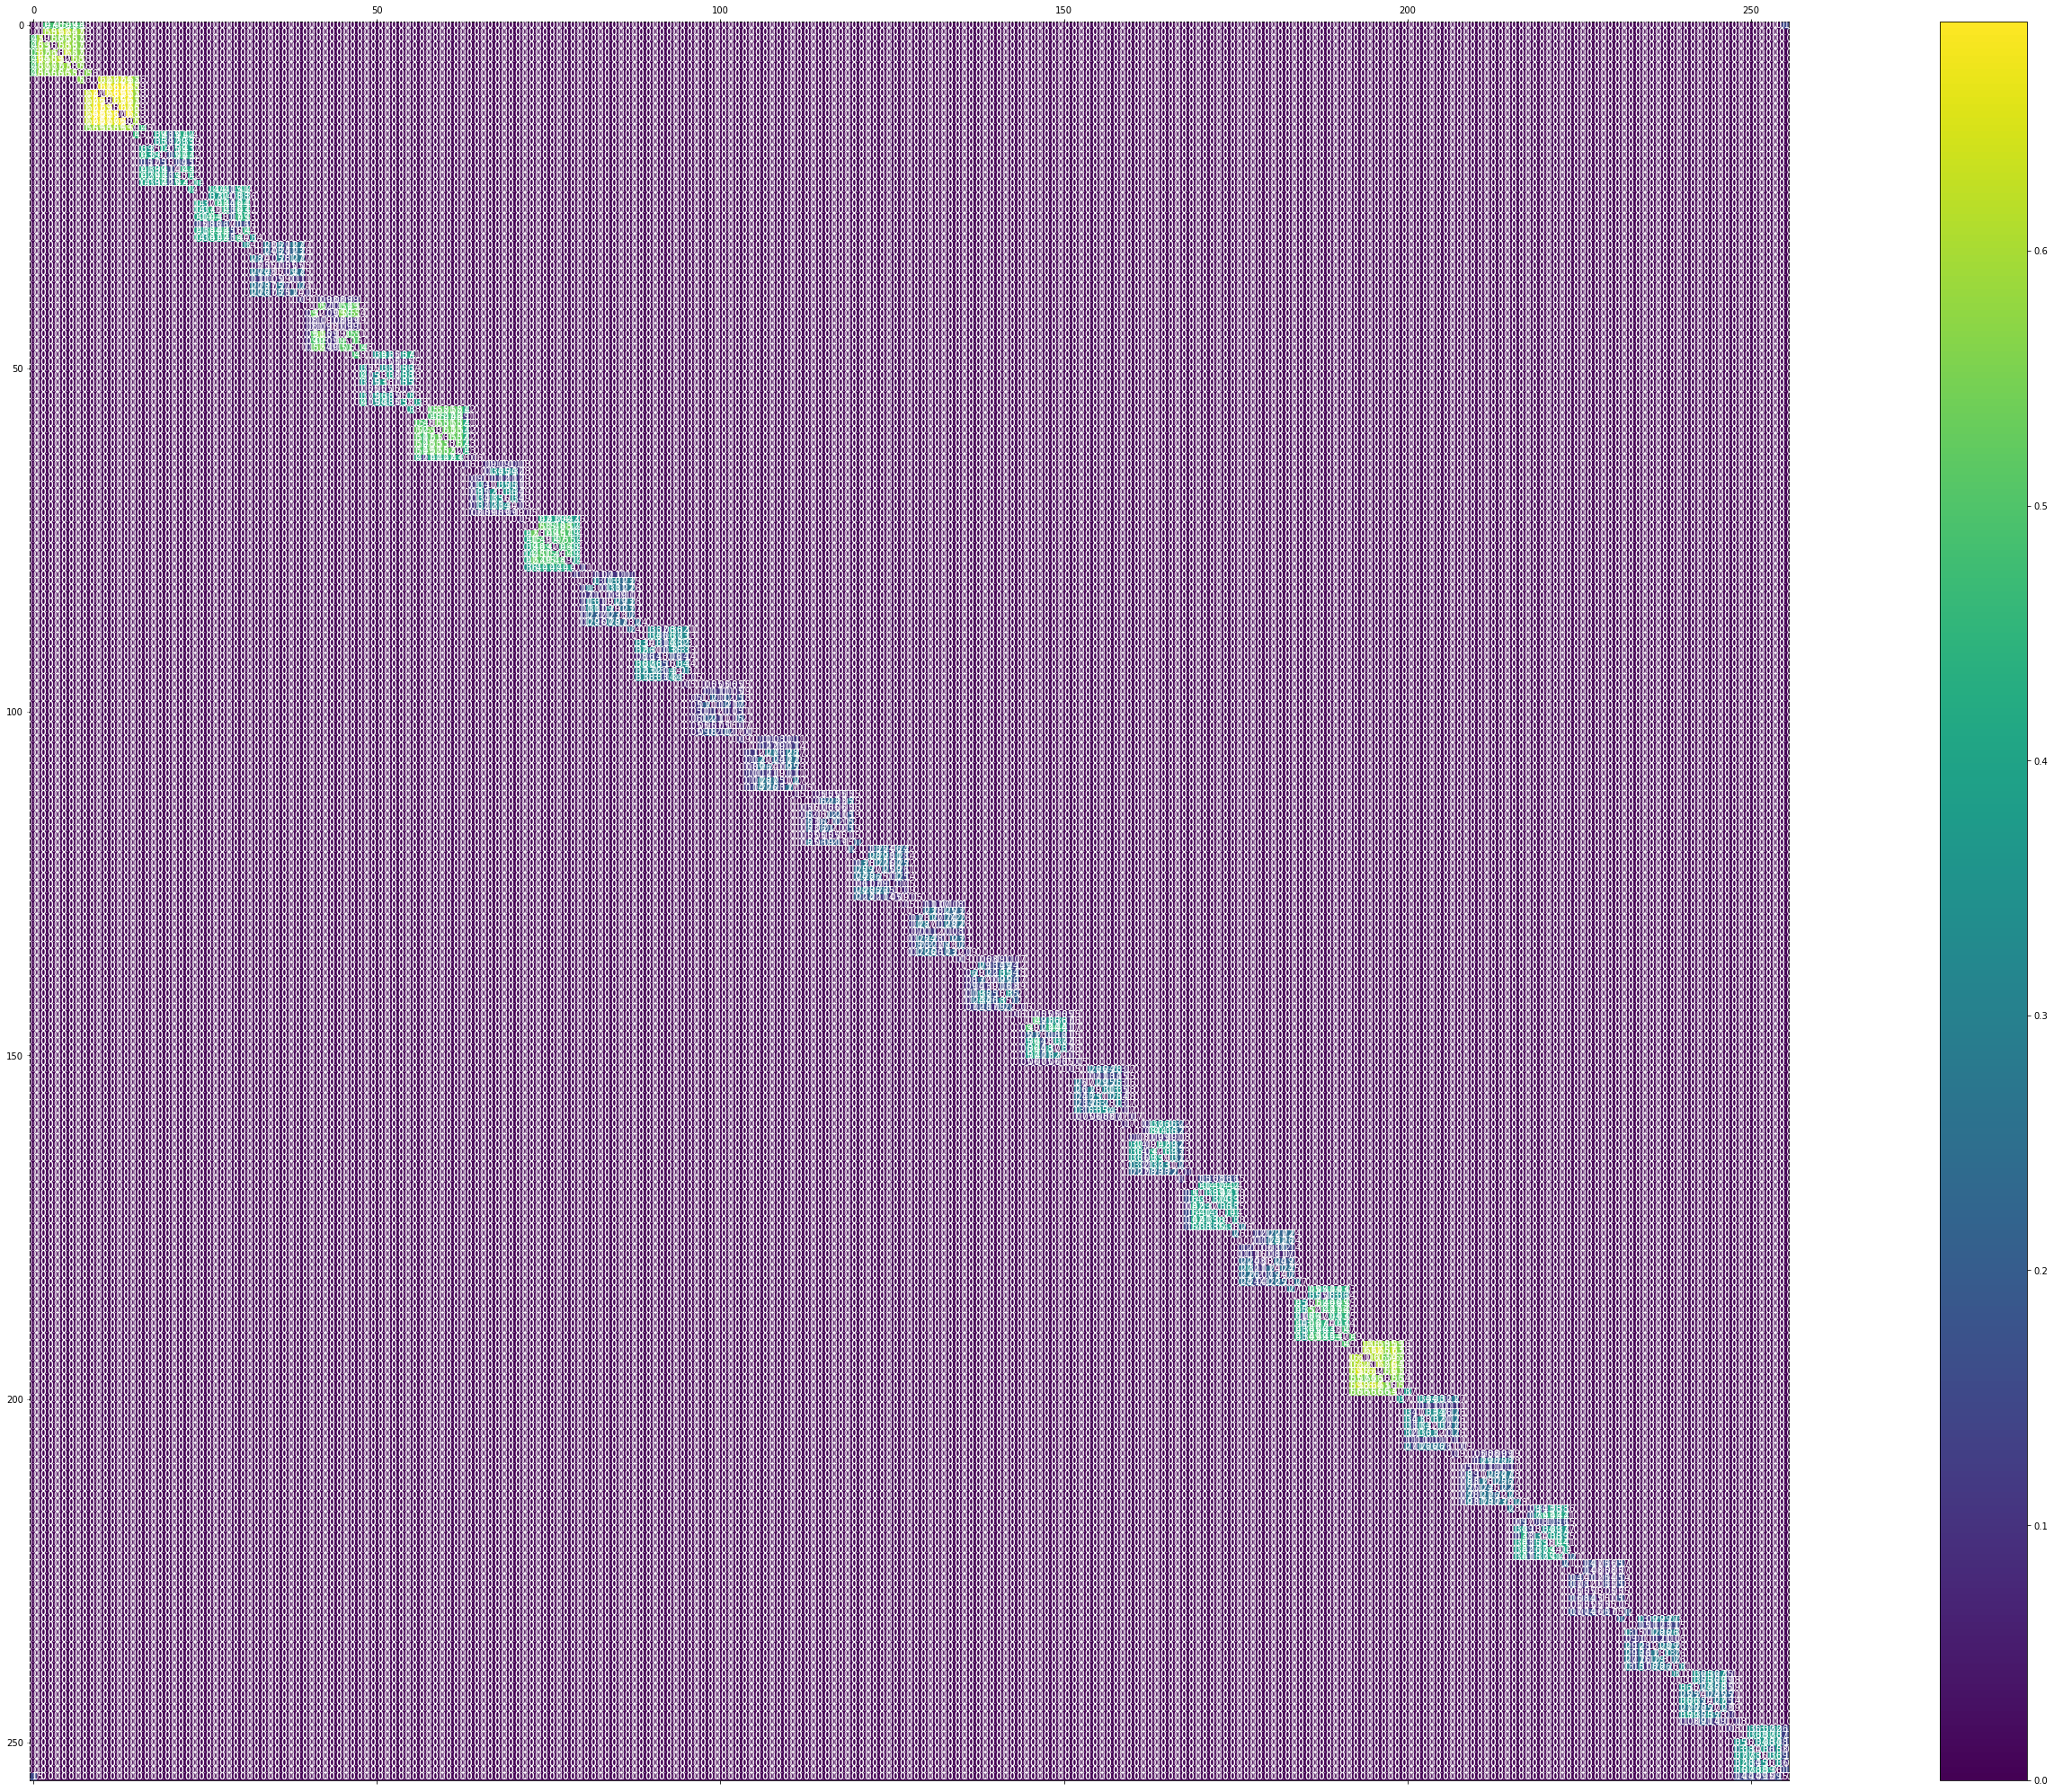

In [8]:
# plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[[0.4708660411407233,
  0.48481983455093003,
  0.4999778568802078,
  0.4882234590729164,
  0.48001645307056734,
  0.484804658307145,
  0.15235432246689337],
 [0.5889324661810614,
  0.5940933876160418,
  0.6156327128939636,
  0.6356225839605972,
  0.5731234614350981,
  0.583788228608632],
 [0.4708660411407233,
  0.5889324661810614,
  0.5612808359493829,
  0.5607608964564984,
  0.5765239238132145,
  0.5742207961559248,
  0.5568595587072621],
 [0.48481983455093003,
  0.5940933876160418,
  0.5612808359493829,
  0.5786692030134251,
  0.5944353693404073,
  0.5698535126354527,
  0.561583158476029],
 [0.4999778568802078,
  0.6156327128939636,
  0.5607608964564984,
  0.5786692030134251,
  0.623733125348396,
  0.5677848774602978,
  0.5641841307943918],
 [0.4882234590729164,
  0.6356225839605972,
  0.5765239238132145,
  0.5944353693404073,
  0.623733125348396,
  0.5817247925525805,
  0.5757262879582405],
 [0.48001645307056734,
  0.5731234614350981,
  0.5742207961559248,
  0.5698535126354527,
  0.

In [11]:
sim.action_histories[0][2]

[<Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>

In [12]:
cumulative_rewards[0][0]

15

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[285.38583115 306.34914   ]
 [292.92163873 281.65185472]
 [289.48548241 305.07551862]
 [288.07876616 308.1821135 ]]


In [14]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [15]:
agents[1]._q_table

array([[246.35151987, 246.20976895],
       [241.350137  , 241.3214143 ],
       [245.90560315, 245.98932466],
       [241.71481048, 216.09605126]])

In [16]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [17]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [18]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

77.0                     DCCC
78.0909090909091         DDCC
82.57142857142857        CCDC
97.2                     DCDC
101.0                    CCCD
107.42307692307692       CDCC
120.88095238095238       DDDD
125.61538461538461       DDDC
129.07692307692307       CCCC
142.05555555555554       CDDD
142.86486486486487       CDDC
159.4                    DDCD
161.33333333333334       CCDD
161.7                    CDCD
164.77777777777777       DCDD
210.0                    DCCD


In [19]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

107102.42857142857       CCDC
104731.0                 DDCC
104115.6                 DCDC
103807.0                 DCCC
102565.5                 CDCC
101585.69047619047       DDDD
100506.33333333333       CCCD
99706.38461538461        CCCC
99446.30769230769        DDDC
97679.85185185185        CDDD
97415.56756756757        CDDC
97142.66666666667        CCDD
94230.8                  DDCD
93809.6                  CDCD
90380.44444444444        DCDD
86653.0                  DCCD


In [20]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DCDD'

In [21]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[285.38583115 306.34914   ]
 [292.92163873 281.65185472]
 [289.48548241 305.07551862]
 [288.07876616 308.1821135 ]]


In [22]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => D
('(C, C)', '(D, D)') => D
